In [3]:
import numpy as np
import pandas as pd
import opendatasets as od
from tqdm.notebook import tqdm
import os
import pickle

from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, LSTM, Embedding, Dropout, add

In [2]:
!pip install opendatasets

In [4]:
od.download("https://www.kaggle.com/datasets/adityajn105/flickr8k?select=Images")

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: lipin97
Your Kaggle Key: ··········
Dataset URL: https://www.kaggle.com/datasets/adityajn105/flickr8k


100%|██████████| 1.04G/1.04G [00:08<00:00, 124MB/s]


In [5]:
base_dir = '/content/flickr8k'
working_dir = '/content/flickr8k_modified'

In [6]:
model = VGG16()
model = Model(inputs = model.inputs, outputs = model.layers[-2].output)
print(model.summary())

553467096/553467096 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 224, 224, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 224, 224, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 112, 112, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 112, 112, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 56, 56, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 28, 28, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 28, 28, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 14, 14, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 7, 7, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ fc1 (Dense)                          │ (None, 4096)                │     102,764,544 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 134,260,544 (512.16 MB)

 Trainable params: 134,260,544 (512.16 MB)

 Non-trainable params: 0 (0.00 B)

None


In [ ]:
#Extracting features from the images

features = {}
directory = os.path.join(base_dir, 'Images')
for img_name in tqdm(os.listdir(directory)):
    img_path = directory + '/' + img_name
    image = load_img(img_path, target_size = (224,224))
    image = img_to_array(image)
    #Here 1 represents batch_size, reshapes into (batch_size, height,width, no. of RGB channels)
    image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
    image = preprocess_input(image)
    feature = model.predict(image, verbose=0)
    image_id = img_name.split('.')[0]
    features[image_id] = feature



In [ ]:
# store features in pickle
pickle.dump(features, open(os.path.join(working_dir, 'features.pkl'), 'wb'))

In [7]:
# load features from pickle
with open('/content/features.pkl', 'rb') as f:
    features = pickle.load(f)

In [8]:
with open(os.path.join(base_dir, 'captions.txt'), 'r') as f:
    next(f)
    captions_doc = f.read()

In [9]:
# create mapping of image to captions
mapped_images = {}
# process lines
for line in tqdm(captions_doc.split('\n')):
    # split the line by comma(,)
    tokens = line.split(',')
    if len(line) < 2:
        continue
    image_id, caption = tokens[0], tokens[1:]
    # remove extension from image ID
    image_id = image_id.split('.')[0]
    # convert caption list to string
    caption = " ".join(caption)
    # create list if needed
    if image_id not in mapped_images:
        mapped_images[image_id] = []
    # store the caption
    mapped_images[image_id].append(caption)

  0%|          | 0/40456 [00:00<?, ?it/s]

In [10]:
len(mapped_images)

8091

Preprocessing the textual data

In [11]:
def preprocess(mapping):

  for key, captions in mapping.items():
    for i in range(len(captions)):
      caption = captions[i]
      caption = caption.lower()
      caption = caption.replace('[^A-Za-z]', '')
      caption = caption.replace('\s+', ' ')
      caption = 'startseq ' + " ".join([word for word in caption.split() if len(caption)>1]) + ' endseq'
      captions[i] = caption

In [12]:
mapped_images['945509052_740bb19bc3']

['A girl sits on the beach under a bright pink sunshade .',
 'A person is sitting under a purple umbrella on the beach .',
 'A woman in a black bathing suit is sitting under a purple umbrella on the beach next to the ocean .',
 'A woman in a black swimsuit sits under a hot-pink umbrella at the beach .',
 'woman sitting on the beach under a pink lawn umbrella .']

In [13]:
preprocess(mapped_images)

In [14]:
mapped_images['945509052_740bb19bc3']

['startseq a girl sits on the beach under a bright pink sunshade . endseq',
 'startseq a person is sitting under a purple umbrella on the beach . endseq',
 'startseq a woman in a black bathing suit is sitting under a purple umbrella on the beach next to the ocean . endseq',
 'startseq a woman in a black swimsuit sits under a hot-pink umbrella at the beach . endseq',
 'startseq woman sitting on the beach under a pink lawn umbrella . endseq']

In [15]:
all_captions = []
for key in mapped_images:
  for caption in mapped_images[key]:
    all_captions.append(caption)

In [16]:
len(all_captions)

40455

In [17]:
all_captions[:5]

['startseq a child in a pink dress is climbing up a set of stairs in an entry way . endseq',
 'startseq a girl going into a wooden building . endseq',
 'startseq a little girl climbing into a wooden playhouse . endseq',
 'startseq a little girl climbing the stairs to her playhouse . endseq',
 'startseq a little girl in a pink dress going into a wooden cabin . endseq']

In [18]:
#Tokenizing the textual data
tokenizer = Tokenizer()
tokenizer.fit_on_texts(all_captions)
vocab_size = len(tokenizer.word_index) + 1

In [19]:
vocab_size

8496

In [20]:
# getting the maximum length of the caption available
max_length = max(len(caption.split()) for caption in all_captions)
max_length

39

Splitting the data for Training and Testing

In [21]:
image_ids = list(mapped_images.keys())
split = int(len(image_ids)*0.90)
train_data = image_ids[:split]
test_data = image_ids[split:]

In [22]:
print("Length of the training data:", len(train_data))
print("Length of the test data:", len(test_data))

Length of the training data: 7281
Length of the test data: 810


In [23]:
caption_ = all_captions[1]
print(caption_)
caption_1 = tokenizer.texts_to_sequences([caption_])
caption_1

startseq a girl going into a wooden building . endseq


[[2, 1, 19, 316, 64, 1, 196, 117, 3]]

In [24]:
#Creating a data generator to get data into batches

def data_generator(data_keys, mapping, features, tokenizer, max_length, vocab_size, batch_size):
    # loop over images
    X1, X2, y = list(), list(), list()
    n = 0
    while 1:
        for key in data_keys:
            n += 1
            captions = mapping[key]
            # process each caption
            for caption in captions:
                # encode the sequence
                seq = tokenizer.texts_to_sequences([caption])[0]
                # split the sequence into X, y pairs
                for i in range(1, len(seq)):
                    # split into input and output pairs
                    in_seq, out_seq = seq[:i], seq[i]
                    # pad input sequence
                    in_seq = pad_sequences([in_seq], maxlen=max_length, padding = 'post')[0]
                    # encode output sequence
                    out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]

                    # store the sequences
                    X1.append(features[key][0])
                    X2.append(in_seq)
                    y.append(out_seq)
            if n == batch_size:
                X1, X2, y = np.array(X1), np.array(X2), np.array(y)
                yield {"image": X1, "text": X2}, y
                X1, X2, y = list(), list(), list()
                n = 0

Model Building

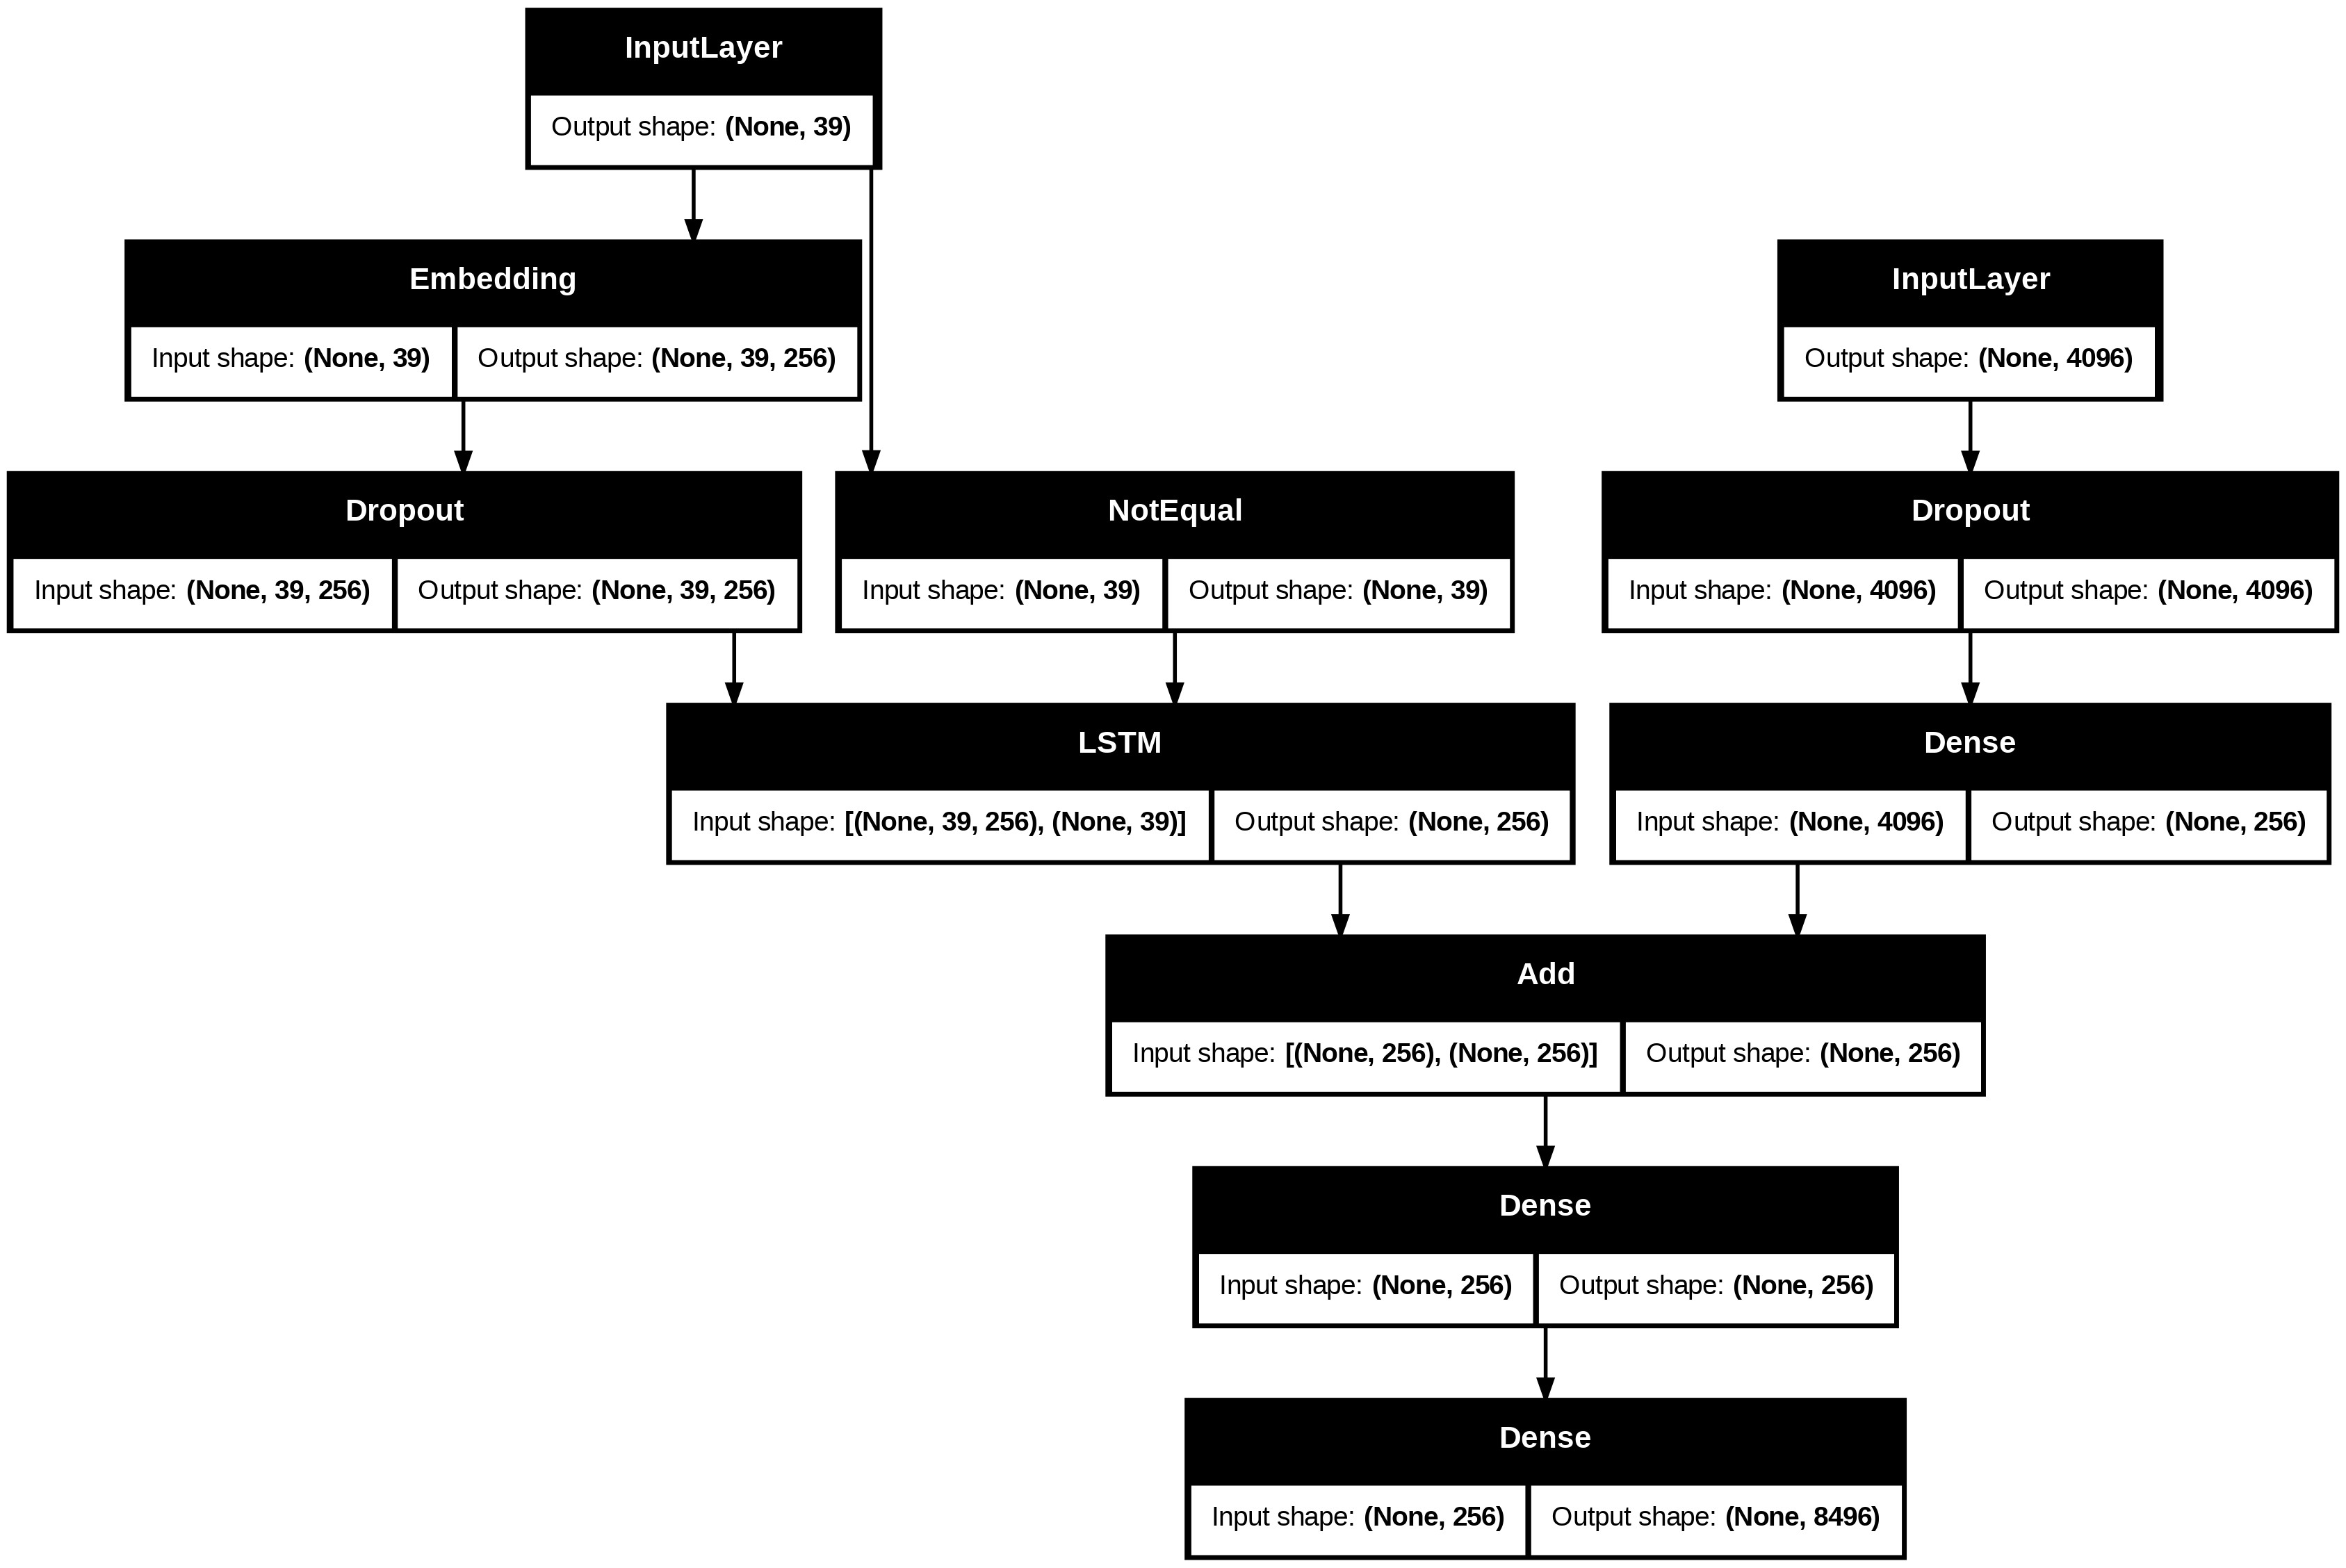

In [25]:
# encoder model
# image feature layers

inputs1 = Input(shape=(4096,), name="image")
fe1 = Dropout(0.4)(inputs1)
fe2 = Dense(256, activation='relu')(fe1)

# sequence feature layers

inputs2 = Input(shape=(max_length,), name="text")
se1 = Embedding(vocab_size, 256, mask_zero=True)(inputs2)
se2 = Dropout(0.4)(se1)
se3 = LSTM(256)(se2)

# decoder model
decoder1 = add([fe2, se3])
decoder2 = Dense(256, activation='relu')(decoder1)
outputs = Dense(vocab_size, activation='softmax')(decoder2)

model = Model(inputs=[inputs1, inputs2], outputs=outputs)
model.compile(loss='categorical_crossentropy', optimizer='adam')

# plot the model
plot_model(model, show_shapes=True)

In [36]:
model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ text (InputLayer)         │ (None, 39)             │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ image (InputLayer)        │ (None, 4096)           │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding_1 (Embedding)   │ (None, 39, 256)        │      2,174,976 │ text[0][0]             │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_2 (Dropout)       │ (None, 4096)           │              0 │ image[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_3 (Dropout)       │ (None, 39, 256)        │              0 │ embedding_1[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ not_equal_1 (NotEqual)    │ (None, 39)             │              0 │ text[0][0]             │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_3 (Dense)           │ (None, 256)            │      1,048,832 │ dropout_2[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm_1 (LSTM)             │ (None, 256)            │        525,312 │ dropout_3[0][0],       │
│                           │                        │                │ not_equal_1[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_1 (Add)               │ (None, 256)            │              0 │ dense_3[0][0],         │
│                           │                        │                │ lstm_1[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_4 (Dense)           │ (None, 256)            │         65,792 │ add_1[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_5 (Dense)           │ (None, 8496)           │      2,183,472 │ dense_4[0][0]          │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 5,998,384 (22.88 MB)

 Trainable params: 5,998,384 (22.88 MB)

 Non-trainable params: 0 (0.00 B)

In [26]:
epochs = 15
batch_size = 35
steps = len(train_data) // batch_size

for i in range(epochs):
    # create data generator
    generator = data_generator(train_data, mapped_images, features, tokenizer, max_length, vocab_size, batch_size)
    # fit for one epoch
    model.fit(generator, epochs=1, steps_per_epoch=steps, verbose=1)

208/208 ━━━━━━━━━━━━━━━━━━━━ 76s 341ms/step - loss: 5.4223
208/208 ━━━━━━━━━━━━━━━━━━━━ 70s 338ms/step - loss: 3.6128
208/208 ━━━━━━━━━━━━━━━━━━━━ 70s 335ms/step - loss: 3.1739
208/208 ━━━━━━━━━━━━━━━━━━━━ 70s 337ms/step - loss: 2.9183
208/208 ━━━━━━━━━━━━━━━━━━━━ 69s 334ms/step - loss: 2.7385
208/208 ━━━━━━━━━━━━━━━━━━━━ 70s 339ms/step - loss: 2.6079
208/208 ━━━━━━━━━━━━━━━━━━━━ 70s 336ms/step - loss: 2.5061
208/208 ━━━━━━━━━━━━━━━━━━━━ 70s 338ms/step - loss: 2.4269
208/208 ━━━━━━━━━━━━━━━━━━━━ 70s 336ms/step - loss: 2.3589
208/208 ━━━━━━━━━━━━━━━━━━━━ 71s 342ms/step - loss: 2.2950
208/208 ━━━━━━━━━━━━━━━━━━━━ 71s 340ms/step - loss: 2.2437
208/208 ━━━━━━━━━━━━━━━━━━━━ 72s 344ms/step - loss: 2.1942
208/208 ━━━━━━━━━━━━━━━━━━━━ 72s 348ms/step - loss: 2.1494
208/208 ━━━━━━━━━━━━━━━━━━━━ 74s 354ms/step - loss: 2.1098
208/208 ━━━━━━━━━━━━━━━━━━━━ 73s 350ms/step - loss: 2.0731


In [27]:
# save the model
model.save(working_dir+'/best_model.h5')

Generating Captions for the Image

In [28]:
def idx_to_word(integer, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == integer:
            return word
    return None

In [29]:
def idx_to_word(integer, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == integer:
            return word
    return None
# generate caption for an image
def predict_caption(model, image, tokenizer, max_length):
    # add start tag for generation process
    in_text = 'startseq'
    # iterate over the max length of sequence
    for i in range(max_length):
        # encode input sequence
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        # pad the sequence
        sequence = pad_sequences([sequence], max_length, padding='post')
        # predict next word
        yhat = model.predict([image, sequence], verbose=0)
        # get index with high probability
        yhat = np.argmax(yhat)
        # convert index to word
        word = idx_to_word(yhat, tokenizer)
        # stop if word not found
        if word is None:
            break
        # append word as input for generating next word
        in_text += " " + word
        # stop if we reach end tag
        if word == 'endseq':
            break

    return in_text

In [30]:
from nltk.translate.bleu_score import corpus_bleu
# validate with test data
actual, predicted = list(), list()

for key in tqdm(test_data):
    # get actual caption
    captions = mapped_images[key]
    # predict the caption for image
    y_pred = predict_caption(model, features[key], tokenizer, max_length)
    # split into words
    actual_captions = [caption.split() for caption in captions]
    y_pred = y_pred.split()
    # append to the list
    actual.append(actual_captions)
    predicted.append(y_pred)

# calcuate BLEU score
print("BLEU-1: %f" % corpus_bleu(actual, predicted, weights=(1.0, 0, 0, 0)))
print("BLEU-2: %f" % corpus_bleu(actual, predicted, weights=(0.5, 0.5, 0, 0)))

  0%|          | 0/810 [00:00<?, ?it/s]

BLEU-1: 0.575858
BLEU-2: 0.379115


Visualizing the results

In [31]:
from PIL import Image
import matplotlib.pyplot as plt
def generate_caption(image_name):
    # load the image
    # image_name = "1001773457_577c3a7d70.jpg"
    image_id = image_name.split('.')[0]
    img_path = os.path.join(base_dir, "Images", image_name)
    image = Image.open(img_path)
    captions = mapped_images[image_id]
    print('---------------------Actual---------------------')
    for caption in captions:
        print(caption)
    # predict the caption
    y_pred = predict_caption(model, features[image_id], tokenizer, max_length)
    print('--------------------Predicted--------------------')
    print(y_pred)
    plt.imshow(image)

---------------------Actual---------------------
startseq a girl sits on the beach under a bright pink sunshade . endseq
startseq a person is sitting under a purple umbrella on the beach . endseq
startseq a woman in a black bathing suit is sitting under a purple umbrella on the beach next to the ocean . endseq
startseq a woman in a black swimsuit sits under a hot-pink umbrella at the beach . endseq
startseq woman sitting on the beach under a pink lawn umbrella . endseq
--------------------Predicted--------------------
startseq a man in a key is walking on the beach endseq


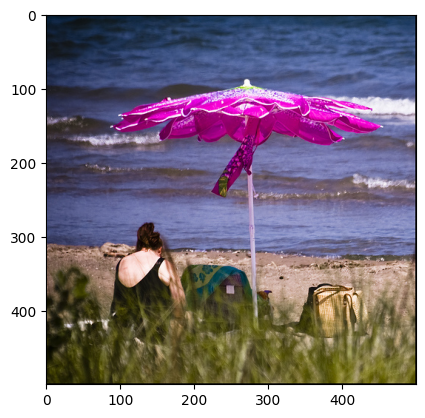

In [32]:
generate_caption("945509052_740bb19bc3.jpg")

---------------------Actual---------------------
startseq a little girl covered in paint sits in front of a painted rainbow with her hands in a bowl . endseq
startseq a little girl is sitting in front of a large painted rainbow . endseq
startseq a small girl in the grass plays with fingerpaints in front of a white canvas with a rainbow on it . endseq
startseq there is a girl with pigtails sitting in front of a rainbow painting . endseq
startseq young girl with pigtails painting outside in the grass . endseq
--------------------Predicted--------------------
startseq a little girl in a red dress is sitting in front of a red canvas endseq


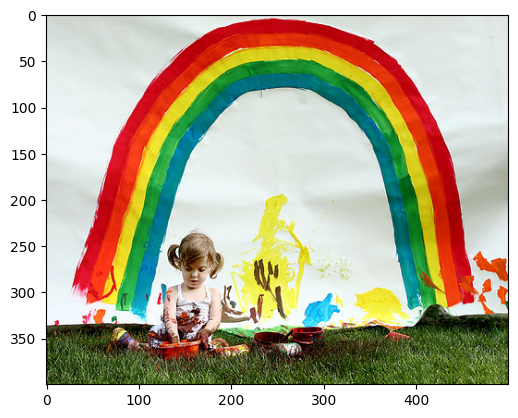

In [33]:
generate_caption("1002674143_1b742ab4b8.jpg")

---------------------Actual---------------------
startseq a brown chow mix dog is standing in front of a van with euro plats in the middle of a messy yard . endseq
startseq a brown dog standing in a muddy yard . endseq
startseq a brown dogs walks near a green van and some junk . endseq
startseq a large brown dog stands in front of a green van in the yard of a house . endseq
startseq a yellow dog is standing in front of a green car and next to a toilet . endseq
--------------------Predicted--------------------
startseq a beagle is standing in a sprinkler endseq


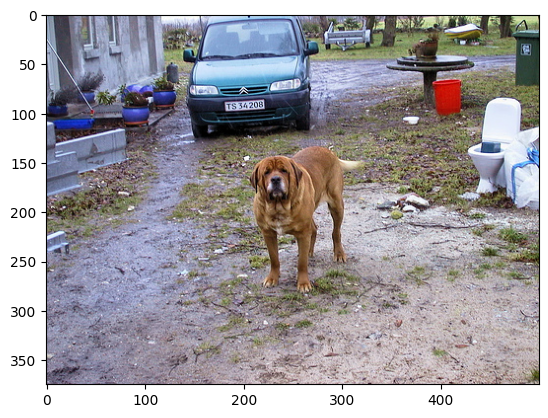

In [36]:
generate_caption('2098418613_85a0c9afea.jpg')

---------------------Actual---------------------
startseq a climber wearing a red headband is pulling himself up some grey rocks high above some green foliage . endseq
startseq a man in a headband climbing a rock . endseq
startseq a man with a red headband climbing a rock cliff looming over greenery . endseq
startseq man climbing a sheet rock face . endseq
startseq man in red headband climbing a rock endseq
--------------------Predicted--------------------
startseq a man climbing a rock wall endseq


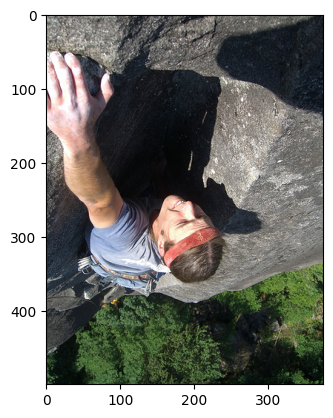

In [35]:
generate_caption('209605542_ca9cc52e7b.jpg')

Testing with Real Image

In [37]:
vgg_model = VGG16()
# restructure the model
vgg_model = Model(inputs=vgg_model.inputs, outputs=vgg_model.layers[-2].output)

In [38]:
image_path = '/content/flickr8k/Images/1244485675_822e6efe60.jpg'
# load image
image = load_img(image_path, target_size=(224, 224))
# convert image pixels to numpy array
image = img_to_array(image)
# reshape data for model
image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
# preprocess image for vgg
image = preprocess_input(image)
# extract features
feature = vgg_model.predict(image, verbose=0)
# predict from the trained model
predict_caption(model, feature, tokenizer, max_length)

'startseq a boy in a blue shirt is standing in a burnished metal bench endseq'